In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [2]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [3]:
class Particle:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.velocity = np.zeros_like(self.position)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

    def update_velocity(self, global_best_position, w, c1, c2):
        r1, r2 = np.random.random(size=(2, self.position.shape[0], self.position.shape[1]))
        self.velocity = w*self.velocity + c1*r1*(self.best_position - self.position) + c2*r2*(global_best_position - self.position)

    def update_position(self):
        self.position += self.velocity

In [4]:
def pso_kmeans(data, n_clusters, n_particles=10, max_iter=100, w=0.5, c1=1, c2=1):
    particles = [Particle(data, n_clusters) for _ in range(n_particles)]
    global_best_score = float('inf')
    global_best_position = None

    for _ in range(max_iter):
        for particle in particles:
            inertia = compute_inertia(particle.position, data)
            if inertia < particle.best_score:
                particle.best_score = inertia
                particle.best_position = np.copy(particle.position)
            
            if inertia < global_best_score:
                global_best_score = inertia
                global_best_position = np.copy(particle.position)

        for particle in particles:
            particle.update_velocity(global_best_position, w, c1, c2)
            particle.update_position()

    final_kmeans = KMeans(n_clusters=n_clusters, init=global_best_position, n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [5]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [8]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]

In [9]:
import gensim.downloader as api
from sklearn.decomposition import PCA
# Load Word2Vec model trained on Google News dataset
print("Loading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')

# Define a function to get the vector representation of a document
def document_vector(doc):
    # Remove punctuation and tokenize the document
    tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in punctuation_set]
    # Filter out tokens that are not in the Word2Vec model's vocabulary
    tokens = [word for word in tokens if word in word2vec_model.key_to_index]
    if len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Calculate the mean of word vectors for tokens in the document
    return np.mean(word2vec_model[tokens], axis=0)

# Obtain Word2Vec embeddings for each document
print("Obtaining Word2Vec embeddings for each document...")
word2vec_embeddings = np.array([document_vector(doc) for doc in processed_data])

Loading Word2Vec model...
Obtaining Word2Vec embeddings for each document...


In [11]:
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(word2vec_embeddings)

In [12]:
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')


In [13]:
n_clusters = 2
kmeans = pso_kmeans(tfidf_matrix_reduced, n_clusters)

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)

In [15]:
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Cluster centers: [[ 7.87559927e-01 -1.01761676e-01  6.67738169e-02 -9.90000647e-03
  -9.76889022e-03  6.95240311e-03 -3.09175276e-03  1.76070118e-03
  -1.52711140e-03 -1.19415531e-03  3.47529945e-04  5.36926673e-04
   2.63387221e-03 -2.15267472e-04 -8.65973940e-04  2.57675303e-04
  -9.10723000e-04 -4.04810155e-04 -8.31040146e-04 -3.85582680e-05
  -1.65304716e-03 -6.71919697e-05 -4.15595336e-04 -1.31244853e-03
   7.73366774e-05 -4.25869570e-04  3.46475834e-04  1.25014863e-04
  -4.69868130e-04 -1.53846195e-04  4.27455961e-04 -2.58577697e-04
  -5.40690016e-05 -2.62884074e-04  7.57634058e-04  4.25372389e-04
   1.20513828e-03  2.36803739e-04 -1.56557013e-04  5.19562018e-05
   3.89279012e-04  2.68650852e-04  1.89262879e-04  7.70993065e-04
   8.82916283e-05  1.67035527e-04  2.08921323e-04 -4.90672770e-04
  -4.22913959e-04 -5.47015516e-04 -1.35723676e-05  1.37428378e-05
   4.96686785e-04  2.80398352e-04  4.75202978e-06 -1.19956399e-04
   4.56641603e-04  1.46824517e-04 -2.58847256e-04  5.266620

In [16]:
from sklearn.decomposition import PCA
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans = pso_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)


0.07840195
0.057591986
0.08962709
0.07249463
0.06692019
0.062448714
0.06453783
0.061831973
0.06174801
0.049597427
0.056749087
0.048434142
0.04604916
0.04492974
0.043605525
0.046945743
0.034534365
0.037388008
0.034991935


In [17]:

silhouette_scores

[0.07840195,
 0.057591986,
 0.08962709,
 0.07249463,
 0.06692019,
 0.062448714,
 0.06453783,
 0.061831973,
 0.06174801,
 0.049597427,
 0.056749087,
 0.048434142,
 0.04604916,
 0.04492974,
 0.043605525,
 0.046945743,
 0.034534365,
 0.037388008,
 0.034991935]

In [18]:
davies_bouldin_scores

[3.7064235814486888,
 3.2849643576024565,
 2.56775602022151,
 2.7925932733180163,
 2.7256301074838905,
 2.8651636308306556,
 2.6781907151845337,
 2.38194711398537,
 2.924070385932441,
 2.727203288525474,
 2.7803013566177484,
 2.9215484614124705,
 2.77997320780867,
 2.9956052204345442,
 2.9675231493026377,
 2.841813059605318,
 2.91853591086897,
 2.8921909278922926,
 2.8854942556924845]

In [19]:
calinski_harabasz_scores

[1099.0437176031128,
 1010.98990592749,
 1015.9793364028264,
 915.0968970345418,
 812.5779394185071,
 738.0083469531876,
 674.4740281182237,
 579.3970417964575,
 597.3228800999963,
 550.6717175464735,
 522.0951784989654,
 510.9329111119921,
 492.327093268823,
 461.87464017004424,
 420.2782259196516,
 424.00381223181165,
 406.1119754200043,
 397.7093639210994,
 382.28171978846245]

C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_20432\1341984160.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_20432\1341984160.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


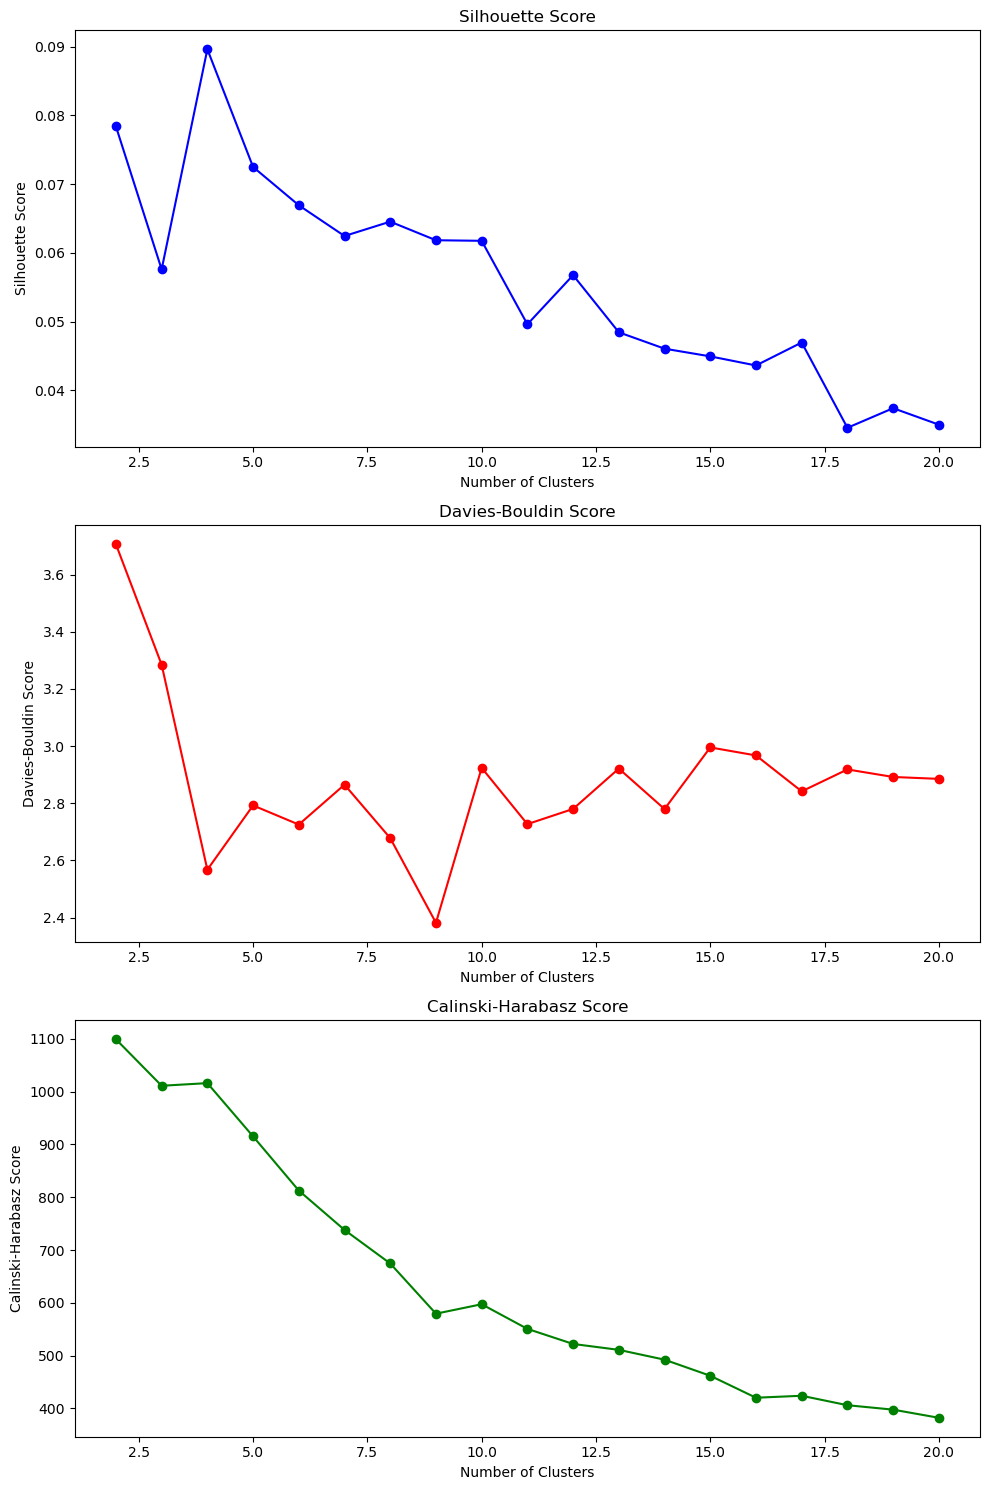

In [20]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_countCuckoo-Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_countCuckoo-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_countCuckoo-Kmeans.png")
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))

In [22]:
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.078402,3.706424,1099.043718
3,0.057592,3.284964,1010.989906
4,0.089627,2.567756,1015.979336
5,0.072495,2.792593,915.096897
6,0.066920,2.725630,812.577939
7,0.062449,2.865164,738.008347
8,0.064538,2.678191,674.474028
9,0.061832,2.381947,579.397042
10,0.061748,2.924070,597.322880
11,0.049597,2.727203,550.671718


In [23]:
df.to_csv('News_Word-Vec_PSO-Kmeans.csv')